In [4]:
import os
import numpy as np
import json
from collections import defaultdict
from shutil import copyfile

# Create Validation Set

In [7]:
# data_dir = "/usr0/home/gis/research/vis_lang/data/oxford_pets"
data_dir = "/nethome/bdevnani3/raid/data/"
os.listdir(data_dir)

['flower_data.tar.gz',
 'fgvc-aircraft-2013b',
 'cifar-100-python.tar.gz',
 'cifar-10-batches-py',
 'annotations',
 'images.tar.gz',
 'images',
 'train',
 'fgvc-aircraft-2013b.tar.gz',
 'oxford_pets',
 'cifar-100-python',
 'annotations.tar.gz',
 'flower_data',
 'cifar-10-python.tar.gz',
 'valid']

In [5]:
def read_annotations(path):
    image_names = []
    with open(path, 'r') as handle:
        for line in handle:
            image_name, _, _, _ = line.strip().split(' ')
            image_names.append(image_name)
    return image_names



In [8]:
trainval_annotations = read_annotations(os.path.join(data_dir, 'annotations', 'trainval.txt'))
test_annotations = read_annotations(os.path.join(data_dir, 'annotations', 'test.txt'))
len(trainval_annotations), len(test_annotations)

(3680, 3669)

In [9]:
image_files = os.listdir(os.path.join(data_dir, 'images'))
len(image_files), image_files[0]

(7393, 'Abyssinian_160.jpg')

In [10]:
def assign_class2ids(annotations):
    class2ids = {}
    for annotation in annotations:
        components = annotation.split('_')
        label = '_'.join(components[:-1])
        ref = components[-1]
        if label not in class2ids:
            class2ids[label] = []
        class2ids[label].append(ref)
    return class2ids

def create_filenames(label, ids):
    filenames = []
    for ref in ids:
        filename = f'{label}_{ref}.jpg'
        filenames.append(filename)
    return filenames

def split_partition(class2ids, proportion=.5):
    split1, split2 = defaultdict(lambda: []), defaultdict(lambda: [])
    for label, ids in class2ids.items():
        np.random.shuffle(ids)
        split_bound = int(len(ids) * proportion)
        split1_files = create_filenames(label, ids[:split_bound])
        split2_files = create_filenames(label, ids[split_bound:])
        split1[label] = split1_files
        split2[label]= split2_files
    return split1, split2
        

In [11]:
trainval_class2ids = assign_class2ids(trainval_annotations)
test_class2ids = assign_class2ids(test_annotations)
len(trainval_class2ids), len(test_class2ids)

(37, 37)

In [12]:
train_set, val_set = split_partition(trainval_class2ids, proportion=.5)
test_set, _ = split_partition(test_class2ids, proportion=1.)
len(train_set), len(val_set), len(test_set)

(37, 37, 37)

In [13]:
list(train_set.keys())[:5]

['Abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle']

In [14]:
len(train_set['Abyssinian'])

50

In [11]:
def create_file_structures(dataset, save_dir, source_dir):
    for label, filenames in dataset.items():
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        for filename in filenames:
            source_file = os.path.join(source_dir, filename)
            dest_file = os.path.join(label_dir, filename)
            copyfile(source_file, dest_file)

In [12]:
create_file_structures(
    train_set, 
    save_dir=os.path.join(data_dir, 'train'),
    source_dir=os.path.join(data_dir, 'images')
)

In [13]:
create_file_structures(
    val_set, 
    save_dir=os.path.join(data_dir, 'valid'),
    source_dir=os.path.join(data_dir, 'images')
)
create_file_structures(
    test_set, 
    save_dir=os.path.join(data_dir, 'test'),
    source_dir=os.path.join(data_dir, 'images')
)

In [15]:
os.listdir(data_dir)

['flower_data.tar.gz',
 'fgvc-aircraft-2013b',
 'cifar-100-python.tar.gz',
 'cifar-10-batches-py',
 'annotations',
 'images.tar.gz',
 'images',
 'train',
 'fgvc-aircraft-2013b.tar.gz',
 'oxford_pets',
 'cifar-100-python',
 'annotations.tar.gz',
 'flower_data',
 'cifar-10-python.tar.gz',
 'valid']

In [16]:
sorted(os.listdir(os.path.join(data_dir, 'train')))

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

# Run Initial Zero Shot Experiment

In [17]:
import os
import clip
import torch
from torchvision import transforms, models

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import argparse
from omegaconf import OmegaConf

import json

from datasets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sn

from columnar import columnar
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import pandas as pd

In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [22]:
class OxfordPetsTmp(ClipExptDataset):
    def __init__(self, num_workers, batch_size, root):
        super().__init__(num_workers, batch_size, root)
        self.name = "OxfordPets"
        self.classes = [
            'Abyssinian',
            'Bengal',
            'Birman',
            'Bombay_cat', # TODO: change this back to Bombay. Bombay_cat is something I added.
            'British_Shorthair',
            'Egyptian_Mau',
            'Maine_Coon',
            'Persian',
            'Ragdoll',
            'Russian_Blue',
            'Siamese',
            'Sphynx',
            'american_bulldog',
            'american_pit_bull_terrier',
            'basset_hound',
            'beagle',
            'boxer',
            'chihuahua',
            'english_cocker_spaniel',
            'english_setter',
            'german_shorthaired',
            'great_pyrenees',
            'havanese',
            'japanese_chin',
            'keeshond',
            'leonberger',
            'miniature_pinscher',
            'newfoundland',
            'pomeranian',
            'pug',
            'saint_bernard',
            'samoyed',
            'scottish_terrier',
            'shiba_inu',
            'staffordshire_bull_terrier',
            'wheaten_terrier',
            'yorkshire_terrier'
        ]

    def get_train_loaders(self, transform_fn=None):

        if transform_fn is None:
            transform_fn = self.train_transform

        train_dataset = datasets.ImageFolder(
            self.root + "oxford_pets/train", transform=transform_fn
        )

        valid_dataset = datasets.ImageFolder(
            self.root + "oxford_pets/valid", transform=transform_fn
        )

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

        return train_loader, valid_loader

    def get_test_loader(self, transform_fn=None):

        if transform_fn is None:
            transform_fn = self.test_transform

        test_dataset = datasets.ImageFolder(
            self.root + "oxford_pets/test", transform=transform_fn
        )

        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

        return test_loader


In [29]:
def clip_zero_shot(
    loader,
    classes,
    zeroshot_weights,
    clip_model_name="ViT-B/32",
):

    global clip_model, clip_preprocess
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def accuracy(output, target, topk=(1,)):
        pred = output.topk(max(topk), 1, True, True)[1].t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return [
            float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())
            for k in topk
        ]

    # lazy load
    if clip_model == None:
        clip_model, clip_preprocess = clip.load(clip_model_name, device)

    per_class_accuracy_top1 = { k:[0,0, classes[k]] for k in range(len(classes))} # correct, total, class_name
    per_class_accuracy_top5 = { k:[0,0, classes[k]] for k in range(len(classes))} 

    with torch.no_grad():
        top1, top5, n = 0.0, 0.0, 0.0
        for i , (images, target) in enumerate(tqdm(loader)):
            images = images.cuda()
            target = target.cuda()

            # predict
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ zeroshot_weights

            # measure accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1 += acc1
            top5 += acc5
            n += images.size(0)
            
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][0]+= acc1
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][1]+= 1

    top1 = (top1 / n) * 100
    top5 = (top5 / n) * 100

    return top1, per_class_accuracy_top1

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            classname = ' '.join(classname.split('_'))
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

In [24]:
dataset_obj = OxfordPetsTmp(4, 1, root="/nethome/bdevnani3/raid/data/")
clip_model, clip_preprocess = clip.load("ViT-B/32", )
train_loader, dev_loader = dataset_obj.get_train_loaders(transform_fn=clip_preprocess)
test_loader = dataset_obj.get_test_loader(transform_fn=clip_preprocess)

In [26]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/pets.txt"

templates = []
with open(phrase_file) as f:
    templates = [line for line in f]

baseline_zw = zeroshot_classifier(dataset_obj.classes,templates)

baseline_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    baseline_zw
)
print(baseline_czs[0])

  0%|          | 0/3669 [00:00<?, ?it/s]

89.42491142000544


In [27]:
templates

['This is a photo of a {}, a pet.']

In [28]:
for template in templates:
    baseline_zw = zeroshot_classifier(dataset_obj.classes,[template])
    test_czs = clip_zero_shot(
        test_loader,
        dataset_obj.classes,
        baseline_zw
    )
    dev_czs = clip_zero_shot(
        dev_loader,
        dataset_obj.classes,
        baseline_zw
    )
    print(template)
    print(dev_czs[0])
    print(test_czs[0])

  0%|          | 0/3669 [00:00<?, ?it/s]

  0%|          | 0/1841 [00:00<?, ?it/s]

This is a photo of a {}, a pet.
85.7686040195546
89.42491142000544


Among the manually selected queries, it appears that keeping the template general with "type" of animal yields the best performance. However, phrases like "big" or "small" do not work as well. I believe this is because the phrases offer a blanket that's not well representative of the type of images.

In [36]:
#Per class performance
def per_class_performance(d, print_out=True):
    x = []
    labels = []
    corr = []
    tot = []
    for el in d:
        x.append((d[el][0]*100)/d[el][1])
        labels.append(d[el][2])
        corr.append(d[el][0])
        tot.append(d[el][1])
    idx = np.argsort(x)
    x = np.array(x)[idx]
    labels = np.array(labels)[idx]
    corr = np.array(corr)[idx]
    tot = np.array(tot)[idx]
    out = {}
    for l,per,c,t in zip(labels,x,corr,tot):
        out[l] = [np.around(per,5),int(c),int(t)]
    if print_out:
        table = columnar([[l, o[0], o[1], o[2]] for l,o in out.items()], ["Class Name", "Accuracy(%)", "Num Correct", "Total"])
        print(table)
    return out

template = 'This is a photo of a {}, a pet.'
baseline_zw = zeroshot_classifier(dataset_obj.classes,[template])
test_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    baseline_zw
)

baseline_pcp = per_class_performance(test_czs[1])

  0%|          | 0/3669 [00:00<?, ?it/s]

|--------------------------|-----------|-----------|-----|
|Class Name                |Accuracy(%)|Num Correct|Total|
|========================================================|
|Ragdoll                   |37.0       |37         |100  |
|--------------------------|-----------|-----------|-----|
|staffordshire_bull_terrier|70.78652   |63         |89   |
|--------------------------|-----------|-----------|-----|
|american_pit_bull_terrier |72.0       |72         |100  |
|--------------------------|-----------|-----------|-----|
|boxer                     |74.74747   |74         |99   |
|--------------------------|-----------|-----------|-----|
|British_Shorthair         |79.0       |79         |100  |
|--------------------------|-----------|-----------|-----|
|english_cocker_spaniel    |80.0       |80         |100  |
|--------------------------|-----------|-----------|-----|
|Bengal                    |80.0       |80         |100  |
|--------------------------|-----------|-----------|----

In [37]:
test_czs[1]

{0: [87.0, 98, 'Abyssinian'],
 1: [80.0, 100, 'Bengal'],
 2: [88.0, 100, 'Birman'],
 3: [86.0, 88, 'Bombay_cat'],
 4: [79.0, 100, 'British_Shorthair'],
 5: [85.0, 97, 'Egyptian_Mau'],
 6: [84.0, 100, 'Maine_Coon'],
 7: [81.0, 100, 'Persian'],
 8: [37.0, 100, 'Ragdoll'],
 9: [97.0, 100, 'Russian_Blue'],
 10: [94.0, 100, 'Siamese'],
 11: [99.0, 100, 'Sphynx'],
 12: [96.0, 100, 'american_bulldog'],
 13: [72.0, 100, 'american_pit_bull_terrier'],
 14: [95.0, 100, 'basset_hound'],
 15: [81.0, 100, 'beagle'],
 16: [74.0, 99, 'boxer'],
 17: [91.0, 100, 'chihuahua'],
 18: [80.0, 100, 'english_cocker_spaniel'],
 19: [97.0, 100, 'english_setter'],
 20: [99.0, 100, 'german_shorthaired'],
 21: [93.0, 100, 'great_pyrenees'],
 22: [92.0, 100, 'havanese'],
 23: [94.0, 100, 'japanese_chin'],
 24: [97.0, 99, 'keeshond'],
 25: [94.0, 100, 'leonberger'],
 26: [100.0, 100, 'miniature_pinscher'],
 27: [93.0, 100, 'newfoundland'],
 28: [98.0, 100, 'pomeranian'],
 29: [98.0, 100, 'pug'],
 30: [91.0, 100, 'sai

In [38]:
id2label = {key: value[-1] for key, value in test_czs[1].items()}
label2id = {value[-1]: key for key, value in test_czs[1].items()}

Hypothesis: Terms with low scores are low because they are poor descriptors of the actual class. E.g. "Bombay" the city is signifantly better known than "Bombay" the cat breed. 

Bombay: Replacing the 'Bombay' with 'Bombay_cat' significantly improves per class performance from 14% to 97.72%.

Ragdoll: Including "cat" with Ragdoll actuall decreases perfromance from 37% to 28%. Why is this? Is it due to overlaps between bombay_cat? Answer: No, this is not the case.



# Synonym Exploration

In [39]:
def generate_synonym_set(word):
    out = []
    try:
        synset = wn.synset(word+".n.01")
        for lemma in synset.lemmas():
            out.append(lemma.name().lower().replace("_", " "))
#         for hypernym in synset.hypernyms():
#             out.append(hypernym.name().lower().replace("_", " ").split(".")[0])
#         for mh in synset.member_holonyms():
#             out.append(mh.name().lower().replace("_", " ").split(".")[0])
        out = list(set(out))
        return out
    except:
        return []

d_synonyms = {}
for c in dataset_obj.classes:
    d_synonyms[c] = set(generate_synonym_set(c.replace(" ", "_")) + [c])

d_synonyms

{'Abyssinian': {'Abyssinian', 'abyssinian', 'abyssinian cat'},
 'Bengal': {'Bengal', 'bengal'},
 'Birman': {'Birman'},
 'Bombay_cat': {'Bombay_cat'},
 'British_Shorthair': {'British_Shorthair'},
 'Egyptian_Mau': {'Egyptian_Mau'},
 'Maine_Coon': {'Maine_Coon'},
 'Persian': {'Persian', 'irani', 'iranian', 'persian'},
 'Ragdoll': {'Ragdoll'},
 'Russian_Blue': {'Russian_Blue'},
 'Siamese': {'Siamese', 'central thai', 'siamese', 'thai'},
 'Sphynx': {'Sphynx'},
 'american_bulldog': {'american_bulldog'},
 'american_pit_bull_terrier': {'american pit bull terrier',
  'american staffordshire terrier',
  'american_pit_bull_terrier',
  'pit bull terrier',
  'staffordshire terrier'},
 'basset_hound': {'basset', 'basset hound', 'basset_hound'},
 'beagle': {'beagle'},
 'boxer': {'boxer', 'pugilist'},
 'chihuahua': {'chihuahua'},
 'english_cocker_spaniel': {'cocker',
  'cocker spaniel',
  'english cocker spaniel',
  'english_cocker_spaniel'},
 'english_setter': {'english setter', 'english_setter'},
 '

There are no synonyms for the pets. 

In [40]:
# def zeroshot_classifier(classnames, templates):
#     with torch.no_grad():
#         zeroshot_weights = []
#         i = 0
#         for cs in tqdm(classnames):
#             syns = Flowers102.wordnet_synonyms[cs] + [cs]
#             texts = []
#             for classname in syns:
#                 texts.extend([
#                     template.format(classname) for template in templates
#                 ])  # format with class
#             texts = clip.tokenize(texts).cuda()  # tokenize
#             class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
#             class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
#             class_embedding = class_embeddings.mean(dim=0)
#             class_embedding /= class_embedding.norm()
#             zeroshot_weights.append(class_embedding)
#         zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
#     return zeroshot_weights

def zeroshot_with_synonyms(class2synonyms, templates):
    with torch.no_grad():
        class_encodings = []
        for synonyms in class2synonyms.values():
            class_descriptors = []
            for synonym in synonyms:
                class_descriptors += [template.format(synonym) for template in templates]
            tokenized_descs = clip.tokenize(class_descriptors).cuda()
            class_embeddings = clip_model.encode_text(tokenized_descs)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            class_encodings.append(class_embedding)
        class_encodings = torch.stack(class_encodings, dim=1).cuda()
    return class_encodings

In [41]:
wordnetsyns_zw = zeroshot_with_synonyms(d_synonyms,[template])

wordnetsyns_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    wordnetsyns_zw
)
print(wordnetsyns_czs[0])

  0%|          | 0/3669 [00:00<?, ?it/s]

84.27364404469883


In [42]:
per_class_performance(wordnetsyns_czs[1])

|--------------------------|-----------|-----------|-----|
|Class Name                |Accuracy(%)|Num Correct|Total|
|========================================================|
|japanese_chin             |5.0        |5          |100  |
|--------------------------|-----------|-----------|-----|
|Ragdoll                   |29.0       |29         |100  |
|--------------------------|-----------|-----------|-----|
|boxer                     |58.58586   |58         |99   |
|--------------------------|-----------|-----------|-----|
|Persian                   |60.0       |60         |100  |
|--------------------------|-----------|-----------|-----|
|staffordshire_bull_terrier|64.04494   |57         |89   |
|--------------------------|-----------|-----------|-----|
|British_Shorthair         |69.0       |69         |100  |
|--------------------------|-----------|-----------|-----|
|english_cocker_spaniel    |73.0       |73         |100  |
|--------------------------|-----------|-----------|----

{'japanese_chin': [5.0, 5, 100],
 'Ragdoll': [29.0, 29, 100],
 'boxer': [58.58586, 58, 99],
 'Persian': [60.0, 60, 100],
 'staffordshire_bull_terrier': [64.04494, 57, 89],
 'British_Shorthair': [69.0, 69, 100],
 'english_cocker_spaniel': [73.0, 73, 100],
 'Bengal': [79.0, 79, 100],
 'beagle': [81.0, 81, 100],
 'german_shorthaired': [82.0, 82, 100],
 'american_pit_bull_terrier': [84.0, 84, 100],
 'Birman': [86.0, 86, 100],
 'american_bulldog': [86.0, 86, 100],
 'Egyptian_Mau': [86.59794, 84, 97],
 'Abyssinian': [86.73469, 85, 98],
 'chihuahua': [88.0, 88, 100],
 'Maine_Coon': [89.0, 89, 100],
 'leonberger': [92.0, 92, 100],
 'saint_bernard': [92.0, 92, 100],
 'havanese': [92.0, 92, 100],
 'Sphynx': [93.0, 93, 100],
 'wheaten_terrier': [93.0, 93, 100],
 'Siamese': [93.0, 93, 100],
 'great_pyrenees': [94.0, 94, 100],
 'Russian_Blue': [94.0, 94, 100],
 'Bombay_cat': [94.31818, 83, 88],
 'basset_hound': [96.0, 96, 100],
 'newfoundland': [96.0, 96, 100],
 'english_setter': [97.0, 97, 100],
 

We have a pretty significant decrease in accuracy for several classes that did very well before introducing synoynms. 
Weird that japanese_chin is horrible yet it has no wordnet synoynms. 

In [12]:
def get_avg_image_encodings(dataloader):
    class2encodings = {}
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm(dataloader)):
            images = images.cuda()

            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            class2encodings[target.numpy()[0]] = image_features
    return class2encodings

In [13]:
class2encodings = get_avg_image_encodings(test_loader)

  0%|          | 0/3669 [00:00<?, ?it/s]

In [14]:
class2encodings.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])

In [32]:
image_encodings = torch.cat(list(class2encodings.values())).cpu()
image_encodings.shape

torch.Size([37, 512])

In [33]:
wordnetsyns_zw.T.shape

torch.Size([37, 512])

0.21191799663594374


<AxesSubplot:>

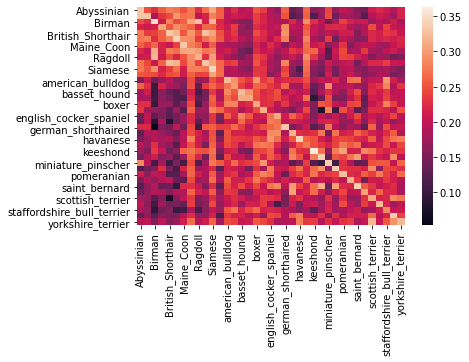

In [42]:
similarities = cosine_similarity(image_encodings, wordnetsyns_zw.T.cpu())
print(similarities.mean())
sn.heatmap(pd.DataFrame(similarities, columns=id2label.values(), index=id2label.values()))

In [47]:
template = 'This is a photo of a {}, a pet.'
raw_zw = zeroshot_classifier(dataset_obj.classes,[template])

0.20529130860907094


<AxesSubplot:>

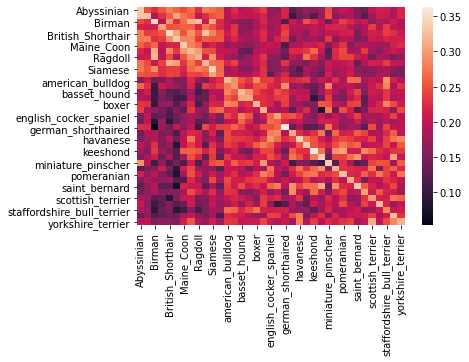

In [48]:
raw_similarities = cosine_similarity(image_encodings, raw_zw.T.cpu())
print(raw_similarities.mean())
sn.heatmap(pd.DataFrame(raw_similarities, columns=id2label.values(), index=id2label.values()))